In [12]:
import os
import sys
from scgt import GeoTiff
sys.path.append('/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/')
sys.path.append('/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/ecoscape-connectivity/')
from EcoLinker.EcoLinker.restorationOptimizer import restorationOptimizer
from ecoscape_connectivity_local import repopulation, util
# import ecoscape_connectivity
from scgt import Tile, GeoTiff
import numpy as np
import torch
import rasterio

DATA_PATH="/Users/nvalett/Documents/Natalie/Species Dist Research/Thesis/EcoLinker/tests/assets"
HABITAT_PATH = os.path.join(DATA_PATH, "smol/hab_smol.tif")
TERRAIN_PATH = os.path.join(DATA_PATH, "smol/terrain.tif")
RESTORED_TERRAIN_PATH = os.path.join(DATA_PATH, "smol/restored_ter_smol.tif")
PERMEABILITY_PATH = os.path.join(DATA_PATH, "paper_repro/transmission_refined_1.csv")
transmission_d = util.read_transmission_csv(PERMEABILITY_PATH)

CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/repop.tif")
RESTORED_CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/repop_after_restoration.tif")
FLOW_PATH = os.path.join(DATA_PATH, "smol/grad.tif")
RESTORED_FLOW_PATH = os.path.join(DATA_PATH, "smol/grad_after_restoration.tif")
DEATH_PATH = os.path.join(DATA_PATH, "smol/death.tif")

optimizer = restorationOptimizer(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50)

Use same seeds

Restoration based on highest death rates:
1. Compute connectivity with pre-determined seeds
2. Compute death layer by taking (flow/p) * (1-p)
3. Find top n pixels with highest death rates
4. Convert pixels to more permiable terrain

In [2]:
# compute connectivity - not needed unless output is needed
hab = GeoTiff.from_file(optimizer.habitat_fn)
hab_tile = hab.get_all_as_tile().m.astype(np.float)
seeds = (torch.rand(400,*(hab_tile.shape)) < 0.002) * hab_tile # 1% of pixels are seeds.

repopulation.compute_connectivity(HABITAT_PATH, TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, transmission_d, single_tile=True, seeds=seeds)
pre_restoration_conn = optimizer.sum_of_tif(CONNECTIVITY_PATH)

/var/folders/py/kw30nbf92q9fms5c67mmgz6m0000gn/T/ipykernel_49025/3440956612.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hab_tile = hab.get_all_as_tile().m.astype(np.float)


TypeError: compute_connectivity() got an unexpected keyword argument 'seeds'

In [3]:
death_tif = optimizer.get_death_layer(optimizer.death_fn)
highest_death = optimizer.get_highest_death_pixels(death_tif)

print(f'Pre-restoration sum of connectivity {pre_restoration_conn}')

pre_restoration_conn = optimizer.sum_of_tif(CONNECTIVITY_PATH)
optimizer.restore_pixels()

# compute connectivity w/ restored terrain
repopulation.compute_connectivity(HABITAT_PATH, RESTORED_TERRAIN_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, transmission_d, single_tile=True, seeds=seeds)
post_restoration_conn = optimizer.sum_of_tif(RESTORED_CONNECTIVITY_PATH)
print(f'Post-restoration sum of connectivity {post_restoration_conn}')

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Pre-restoration sum of connectivity 3393799


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Post-restoration sum of connectivity 3395963


Compare new (post-restoration) connectivity to old connectivity
    - Use same seeds to enforce determinism

In [4]:
# change in connectivity:
delta_conn = int(post_restoration_conn) - int(pre_restoration_conn)
percent_change = delta_conn / pre_restoration_conn

print(f'pre-restoration sum of connectivity {pre_restoration_conn}')
print(f'post-restoration sum of connectivity {post_restoration_conn}')
print(f'change in connectivity: {delta_conn}, or {percent_change.round(7)}%')

pre-restoration sum of connectivity 3393799
post-restoration sum of connectivity 3395963
change in connectivity: 2164, or 0.0006376%


Try to compute regional connectivity gain for each restored pixel...

In [13]:
PRE_TER = os.path.join(DATA_PATH, "smol/pre_ter.tif")
PRE_HAB = os.path.join(DATA_PATH, "smol/pre_hab.tif")
PRE_CONN = os.path.join(DATA_PATH, "smol/pre_conn.tif")
PRE_FLOW = os.path.join(DATA_PATH, "smol/pre_flow.tif")
POST_TER = os.path.join(DATA_PATH, "smol/post_ter.tif")
POST_HAB = os.path.join(DATA_PATH, "smol/post_hab.tif")
POST_CONN = os.path.join(DATA_PATH, "smol/post_conn.tif")
POST_FLOW = os.path.join(DATA_PATH, "smol/post_flow.tif")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


{(243, 202): 36, (293, 199): 36, (207, 206): 36, (33, 132): 36, (236, 203): 36, (33, 133): 36, (262, 201): 35, (237, 203): 35, (246, 201): 35, (83, 143): 35, (72, 143): 35, (91, 151): 34, (82, 143): 34, (207, 205): 34, (63, 129): 34, (89, 146): 34, (245, 201): 34, (252, 199): 34, (242, 202): 33, (142, 188): 33, (224, 202): 33, (290, 202): 33, (184, 202): 33, (244, 201): 33, (262, 202): 33, (261, 202): 32, (89, 150): 32, (88, 146): 32, (193, 203): 32, (138, 162): 32, (78, 144): 32, (131, 167): 32, (130, 167): 32, (89, 147): 32, (189, 203): 32, (64, 129): 32, (134, 168): 32, (292, 199): 31, (238, 203): 31, (191, 204): 31, (187, 201): 31, (143, 191): 31, (224, 201): 31, (241, 202): 31, (232, 21): 31, (261, 201): 31, (268, 201): 31, (228, 196): 31, (143, 190): 31, (82, 142): 30}


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

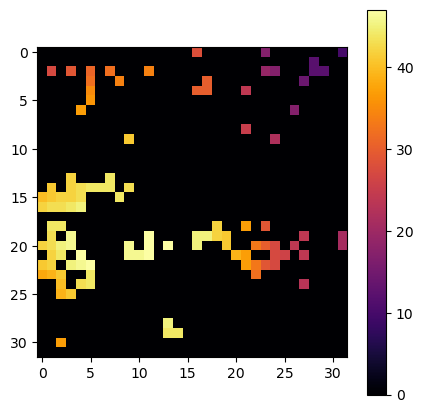

Restoring pixel (243, 202) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

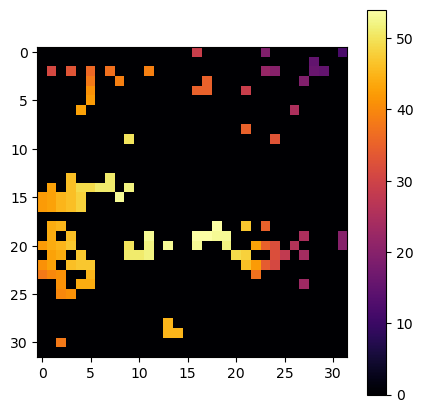

pre-restoration sum of connectivity 3996
post-restoration sum of connectivity 4436
change in connectivity: 440, or 0.1101101%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

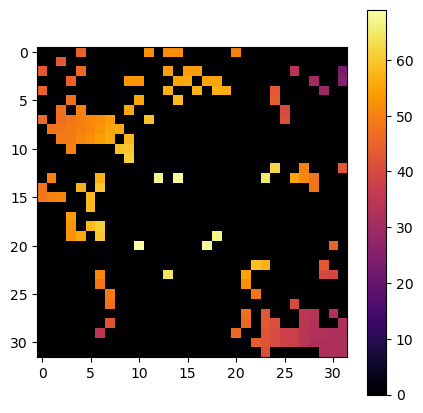

Restoring pixel (293, 199) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

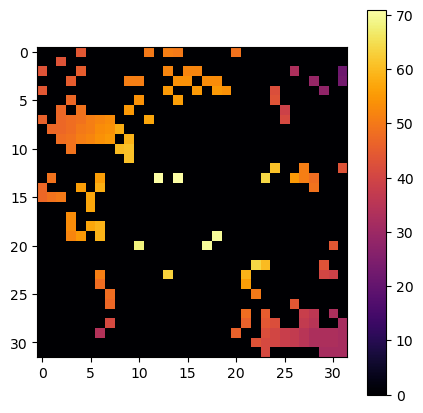

pre-restoration sum of connectivity 7023
post-restoration sum of connectivity 6997
change in connectivity: -26, or -0.0037021%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

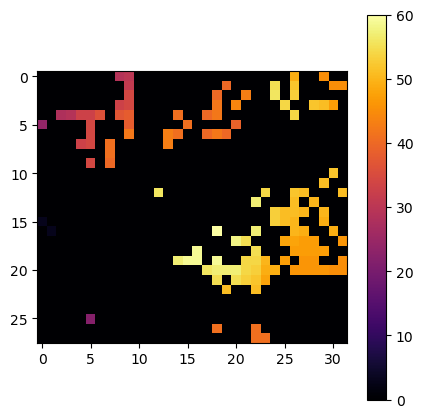

Restoring pixel (207, 206) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

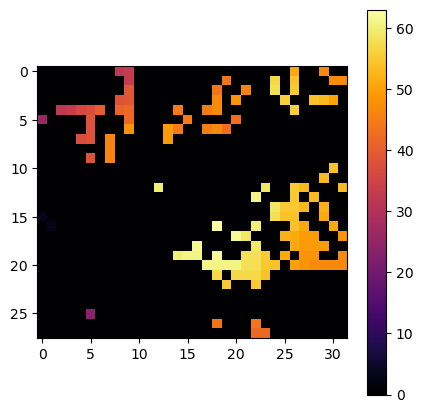

pre-restoration sum of connectivity 5877
post-restoration sum of connectivity 6308
change in connectivity: 431, or 0.0733367%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

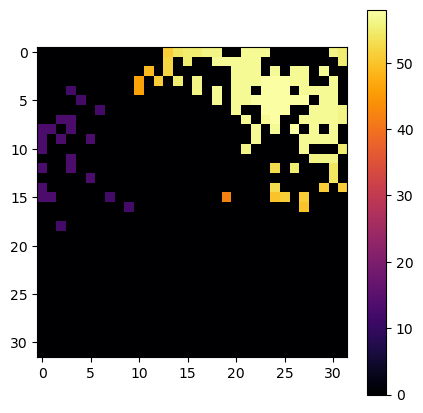

Restoring pixel (33, 132) from permiability 0.01454014598540146 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

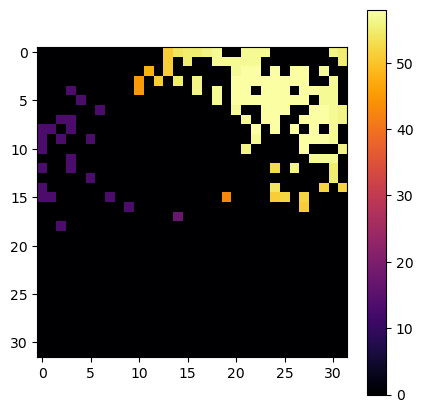

pre-restoration sum of connectivity 6304
post-restoration sum of connectivity 6367
change in connectivity: 63, or 0.0099937%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

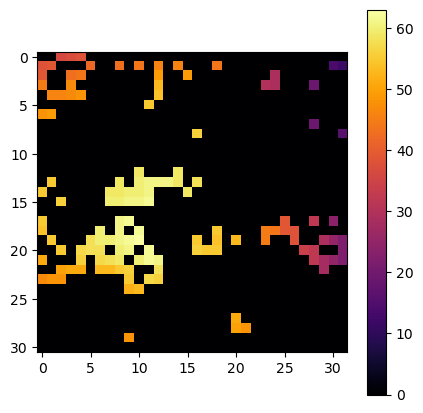

Restoring pixel (236, 203) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

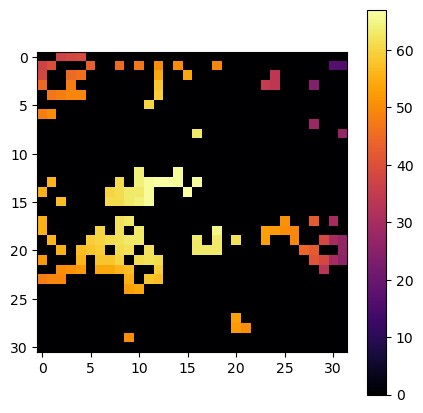

pre-restoration sum of connectivity 6579
post-restoration sum of connectivity 7035
change in connectivity: 456, or 0.0693114%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

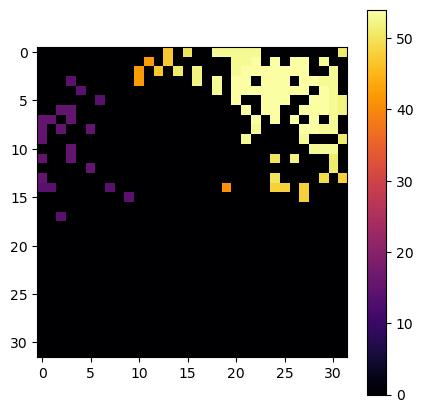

Restoring pixel (33, 133) from permiability 0.01454014598540146 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

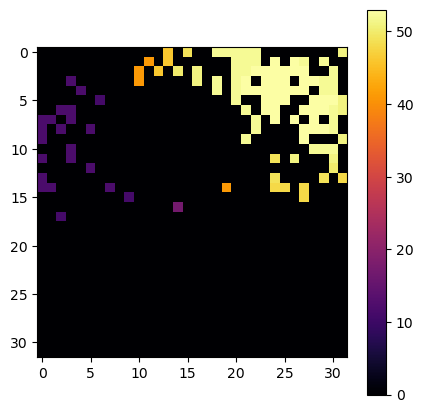

pre-restoration sum of connectivity 5392
post-restoration sum of connectivity 5255
change in connectivity: -137, or -0.025408%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

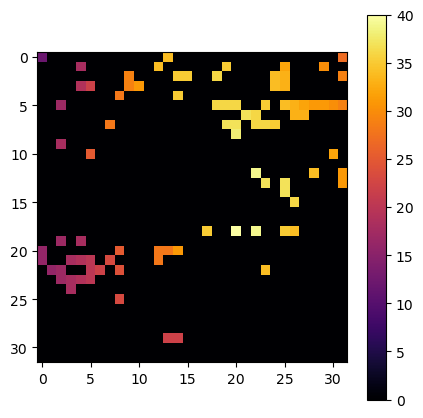

Restoring pixel (262, 201) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

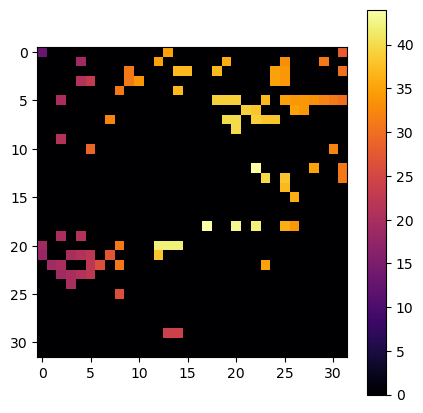

pre-restoration sum of connectivity 2569
post-restoration sum of connectivity 2798
change in connectivity: 229, or 0.0891397%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

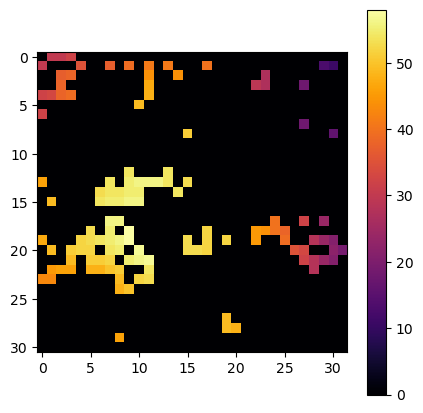

Restoring pixel (237, 203) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

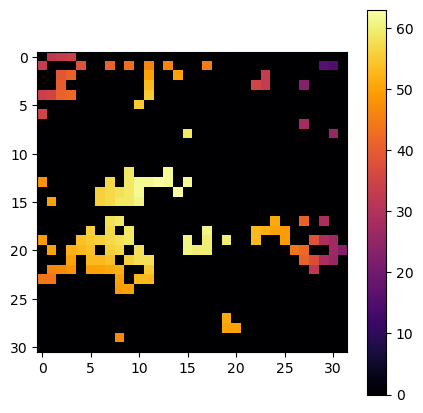

pre-restoration sum of connectivity 5613
post-restoration sum of connectivity 6146
change in connectivity: 533, or 0.0949581%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

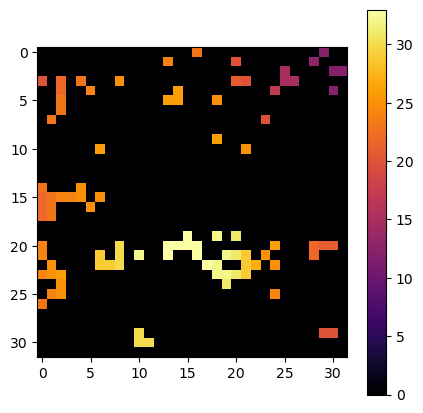

Restoring pixel (246, 201) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

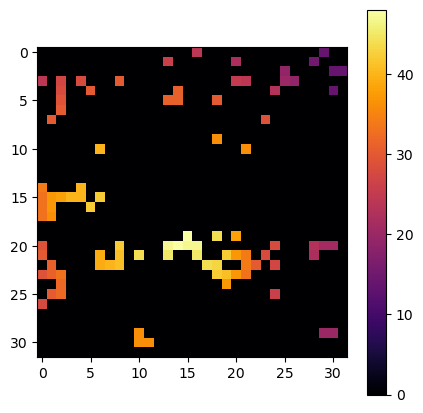

pre-restoration sum of connectivity 2374
post-restoration sum of connectivity 3076
change in connectivity: 702, or 0.2957035%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

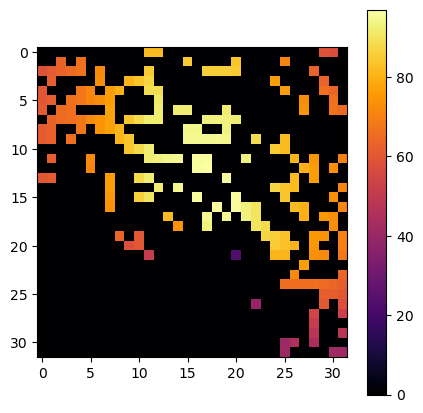

Restoring pixel (83, 143) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

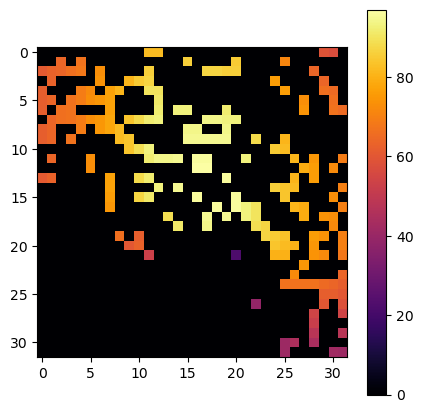

pre-restoration sum of connectivity 15877
post-restoration sum of connectivity 15986
change in connectivity: 109, or 0.0068653%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

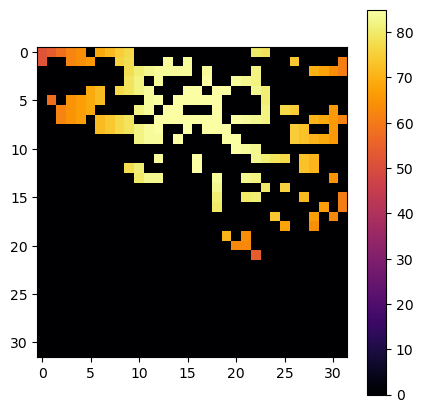

Restoring pixel (72, 143) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

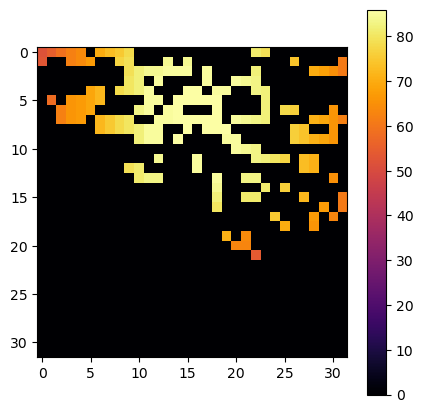

pre-restoration sum of connectivity 12951
post-restoration sum of connectivity 13034
change in connectivity: 83, or 0.0064088%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

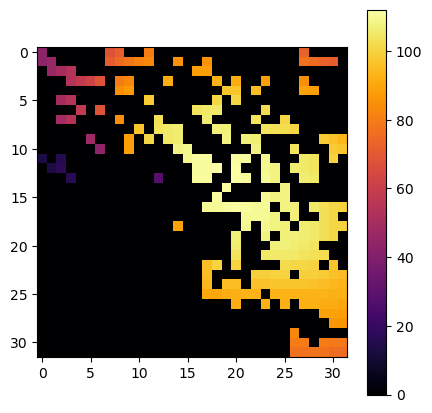

Restoring pixel (91, 151) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

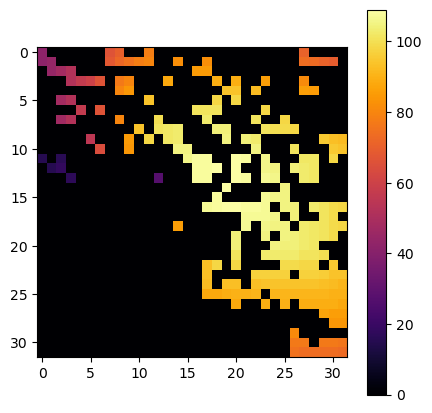

pre-restoration sum of connectivity 22987
post-restoration sum of connectivity 22406
change in connectivity: -581, or -0.0252752%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

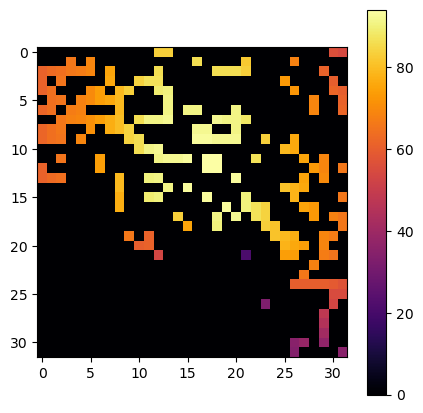

Restoring pixel (82, 143) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

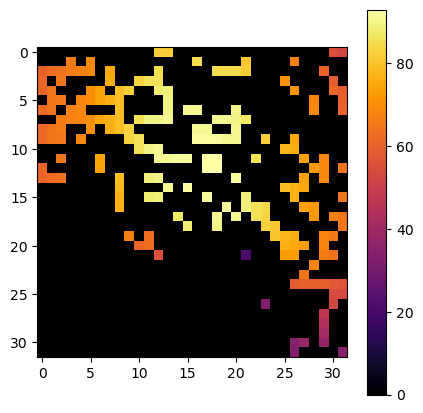

pre-restoration sum of connectivity 15143
post-restoration sum of connectivity 15049
change in connectivity: -94, or -0.0062075%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

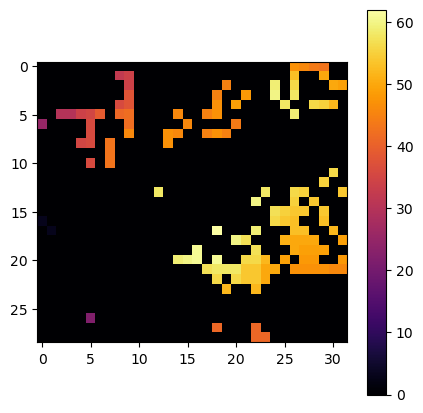

Restoring pixel (207, 205) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

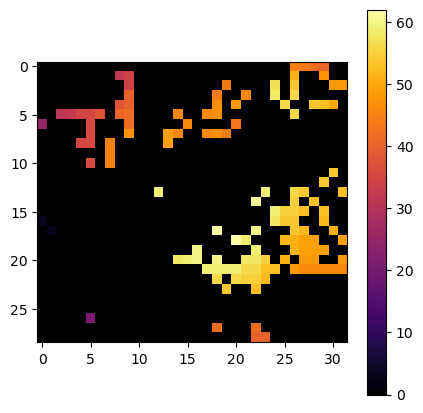

pre-restoration sum of connectivity 6413
post-restoration sum of connectivity 6423
change in connectivity: 10, or 0.0015593%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

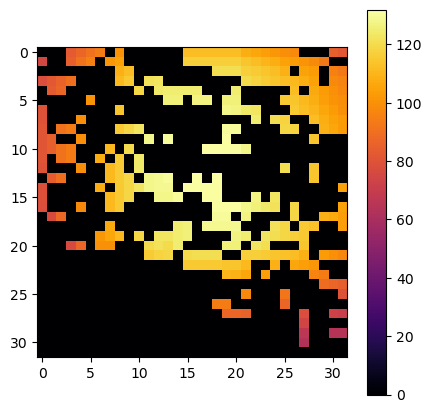

Restoring pixel (63, 129) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

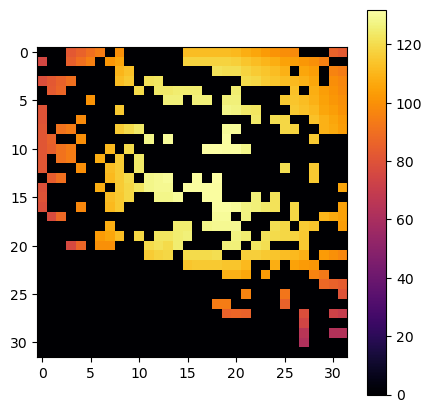

pre-restoration sum of connectivity 34623
post-restoration sum of connectivity 34648
change in connectivity: 25, or 0.0007221%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

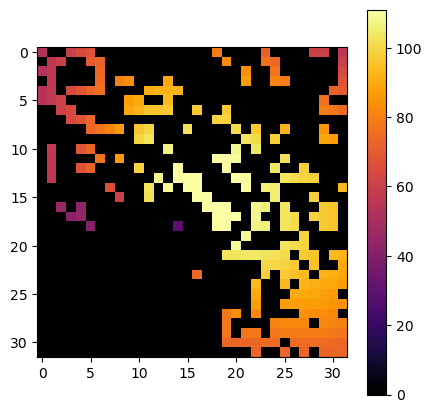

Restoring pixel (89, 146) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

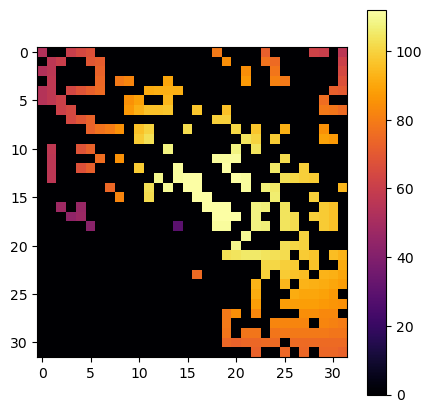

pre-restoration sum of connectivity 22410
post-restoration sum of connectivity 22536
change in connectivity: 126, or 0.0056225%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

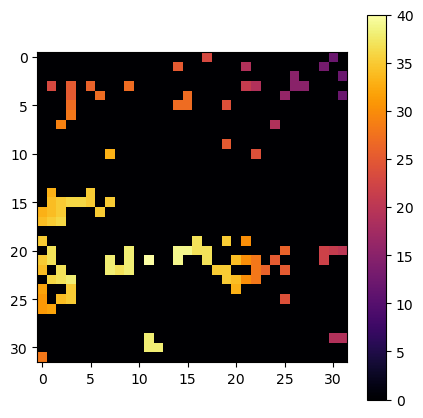

Restoring pixel (245, 201) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

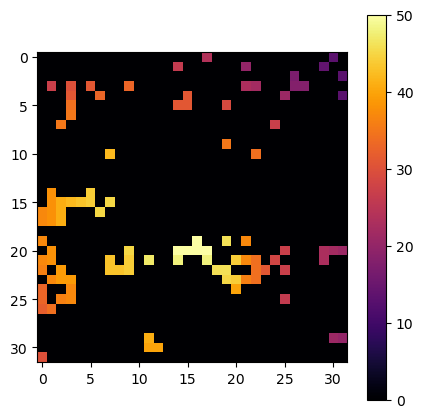

pre-restoration sum of connectivity 3075
post-restoration sum of connectivity 3583
change in connectivity: 508, or 0.1652033%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

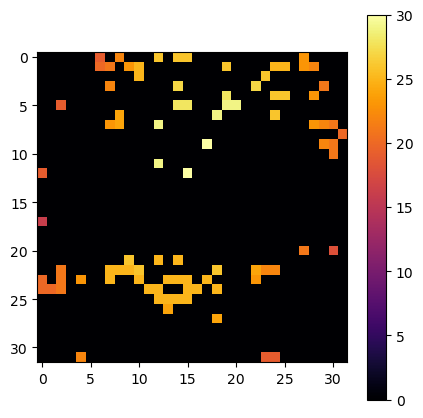

Restoring pixel (252, 199) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

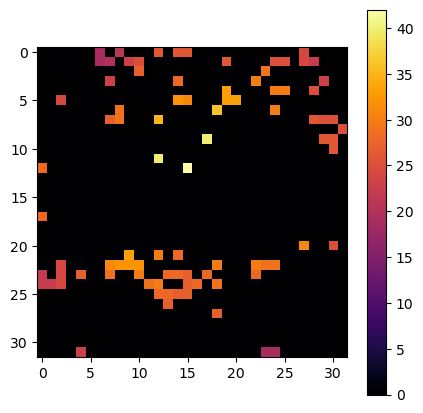

pre-restoration sum of connectivity 2127
post-restoration sum of connectivity 2448
change in connectivity: 321, or 0.1509168%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

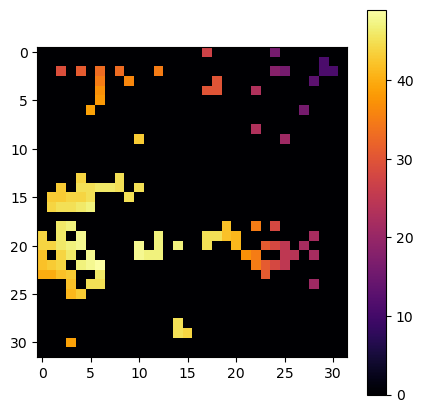

Restoring pixel (242, 202) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

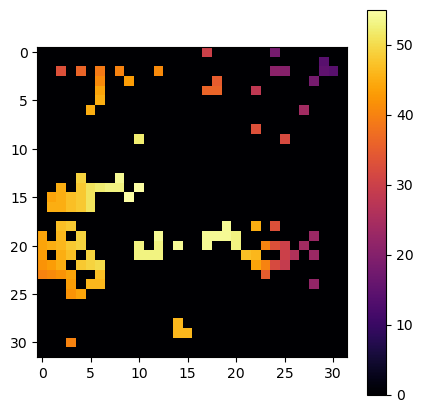

pre-restoration sum of connectivity 4230
post-restoration sum of connectivity 4710
change in connectivity: 480, or 0.1134752%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

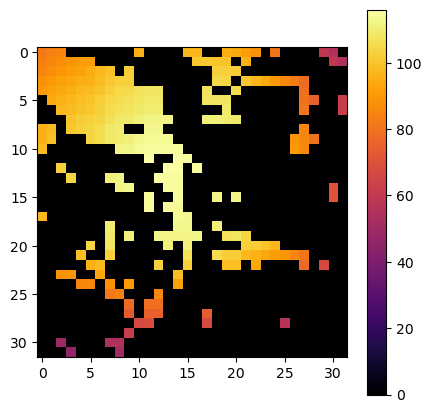

Restoring pixel (142, 188) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

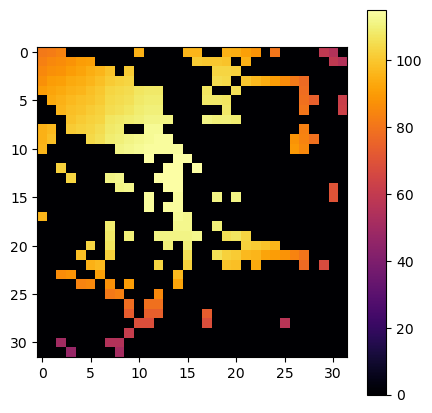

pre-restoration sum of connectivity 25059
post-restoration sum of connectivity 24905
change in connectivity: -154, or -0.0061455%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

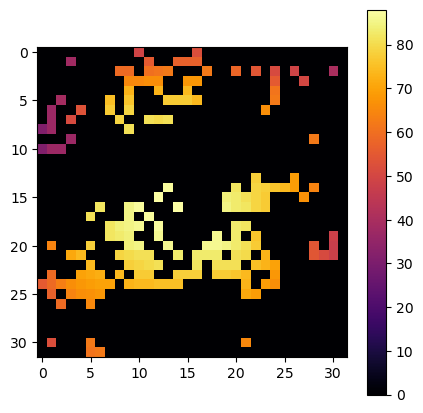

Restoring pixel (224, 202) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

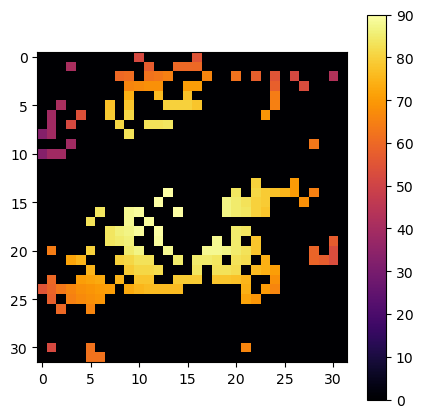

pre-restoration sum of connectivity 13212
post-restoration sum of connectivity 13559
change in connectivity: 347, or 0.026264%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

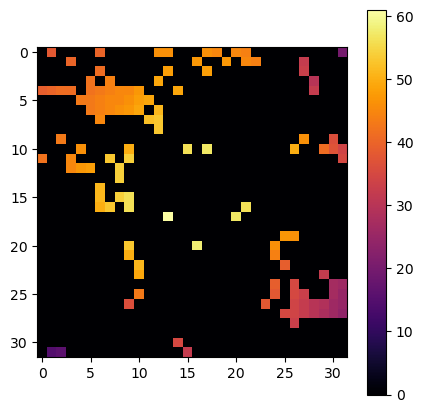

Restoring pixel (290, 202) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

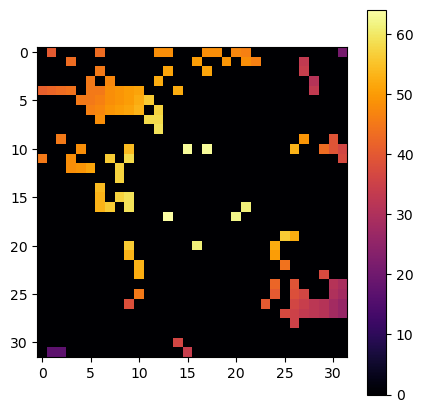

pre-restoration sum of connectivity 5310
post-restoration sum of connectivity 5690
change in connectivity: 380, or 0.0715631%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

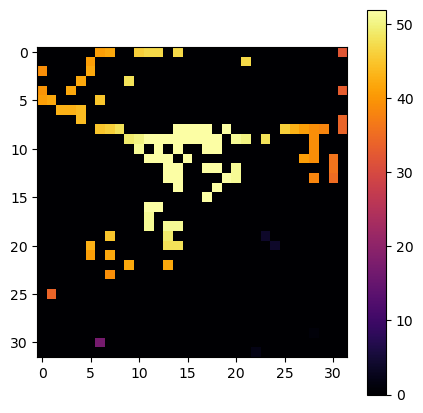

Restoring pixel (184, 202) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

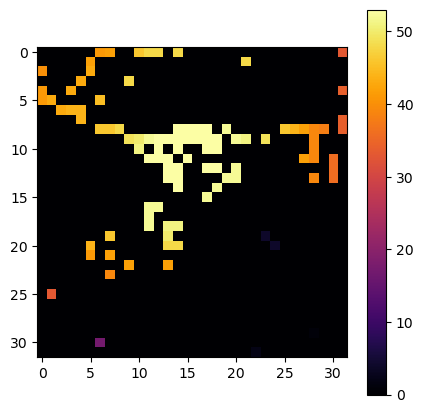

pre-restoration sum of connectivity 4517
post-restoration sum of connectivity 4572
change in connectivity: 55, or 0.0121762%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

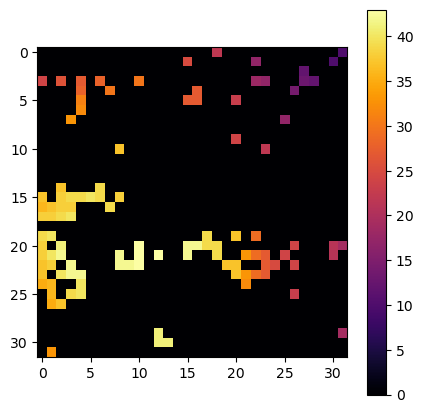

Restoring pixel (244, 201) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

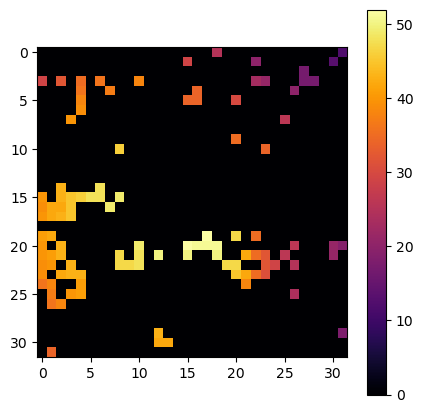

pre-restoration sum of connectivity 3556
post-restoration sum of connectivity 4101
change in connectivity: 545, or 0.1532621%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

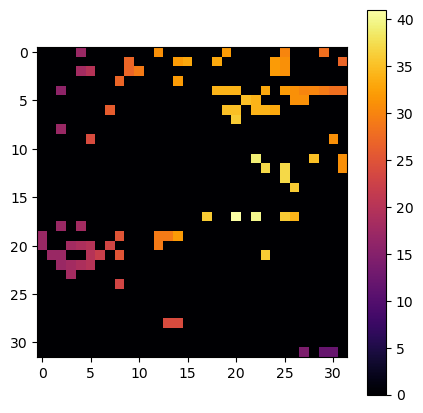

Restoring pixel (262, 202) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

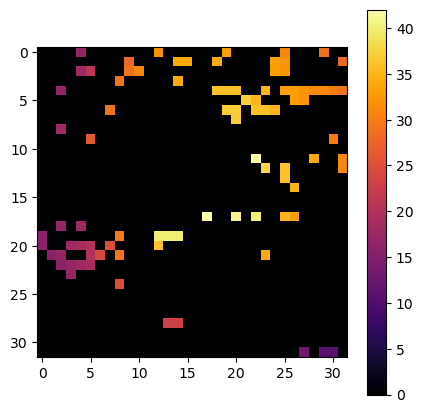

pre-restoration sum of connectivity 2465
post-restoration sum of connectivity 2571
change in connectivity: 106, or 0.043002%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

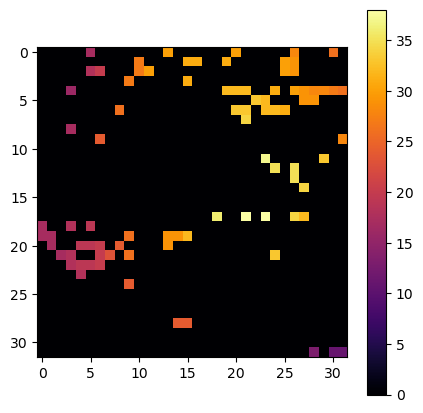

Restoring pixel (261, 202) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

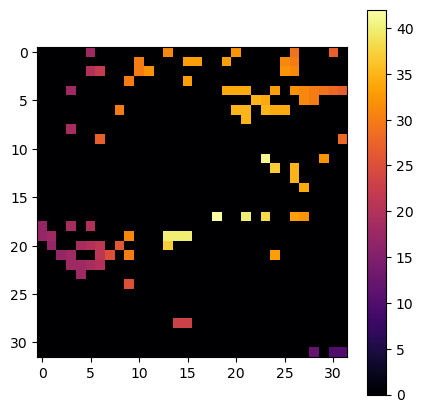

pre-restoration sum of connectivity 2303
post-restoration sum of connectivity 2450
change in connectivity: 147, or 0.0638298%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

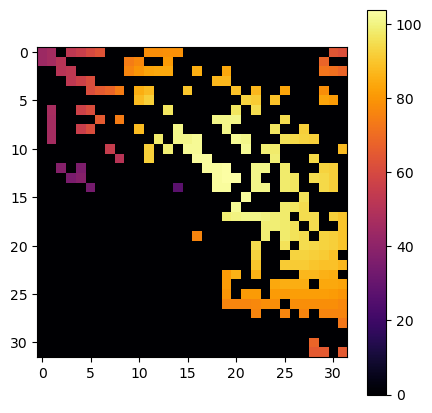

Restoring pixel (89, 150) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

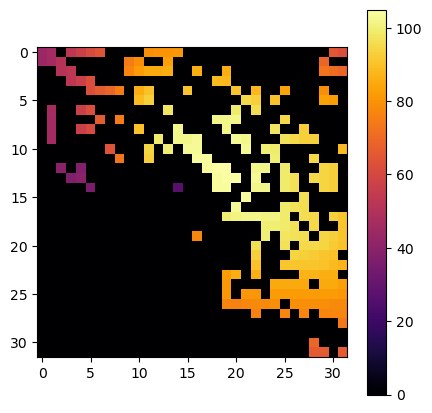

pre-restoration sum of connectivity 19471
post-restoration sum of connectivity 19692
change in connectivity: 221, or 0.0113502%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

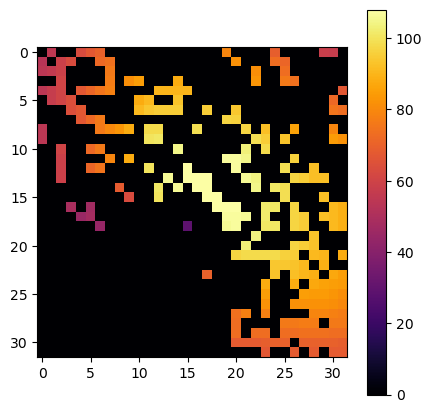

Restoring pixel (88, 146) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

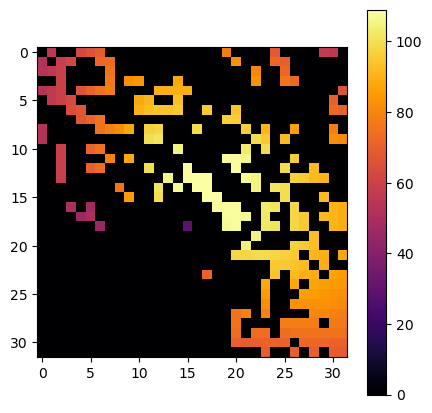

pre-restoration sum of connectivity 20732
post-restoration sum of connectivity 20809
change in connectivity: 77, or 0.0037141%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

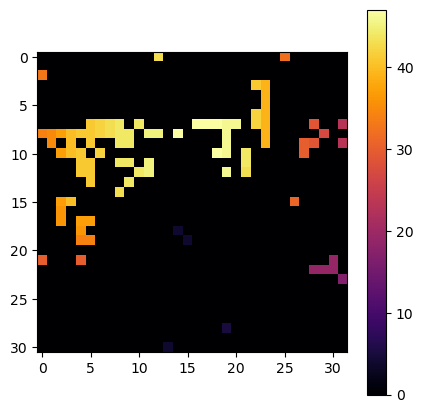

Restoring pixel (193, 203) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

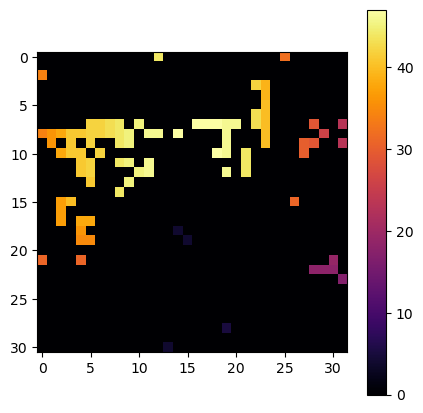

pre-restoration sum of connectivity 3450
post-restoration sum of connectivity 3488
change in connectivity: 38, or 0.0110145%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

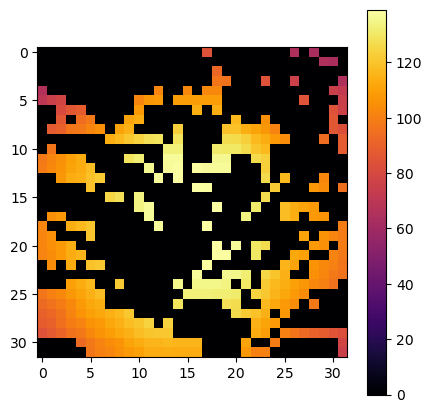

Restoring pixel (138, 162) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

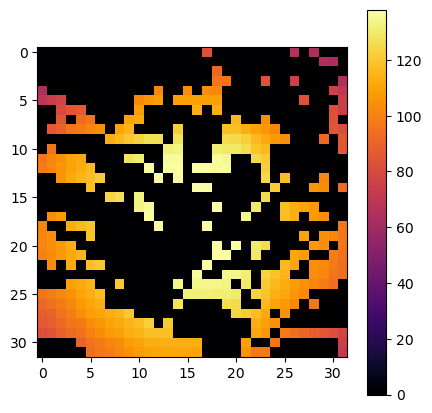

pre-restoration sum of connectivity 38761
post-restoration sum of connectivity 38285
change in connectivity: -476, or -0.0122804%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

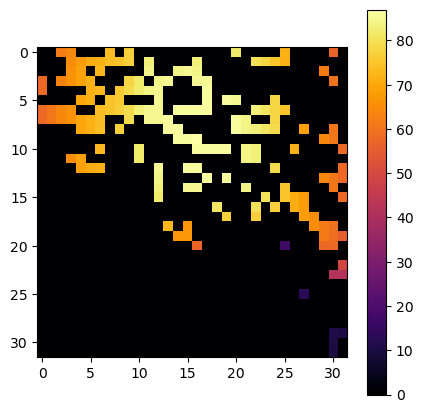

Restoring pixel (78, 144) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

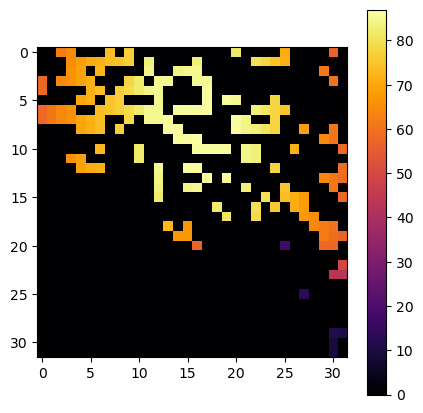

pre-restoration sum of connectivity 13081
post-restoration sum of connectivity 13087
change in connectivity: 6, or 0.0004587%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

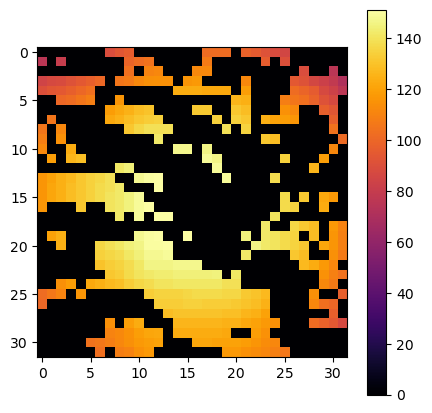

Restoring pixel (131, 167) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

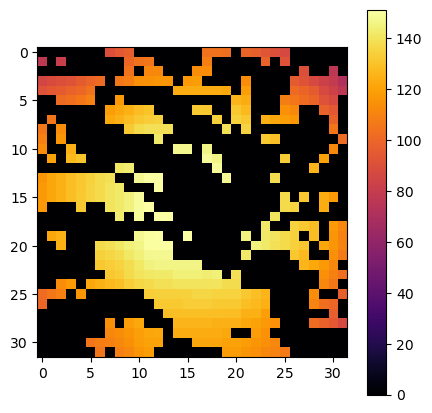

pre-restoration sum of connectivity 49502
post-restoration sum of connectivity 49551
change in connectivity: 49, or 0.0009899%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

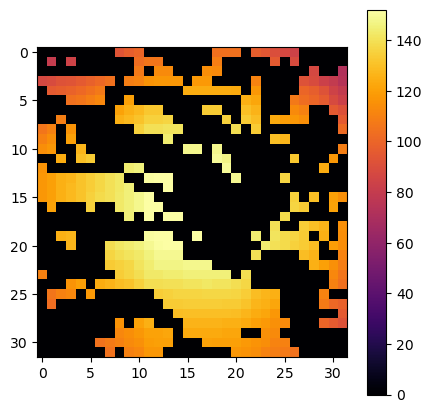

Restoring pixel (130, 167) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

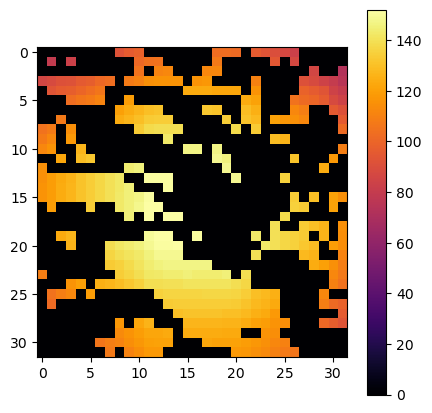

pre-restoration sum of connectivity 49819
post-restoration sum of connectivity 49716
change in connectivity: -103, or -0.0020675%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

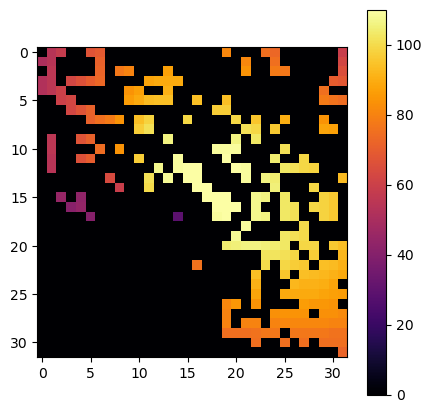

Restoring pixel (89, 147) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

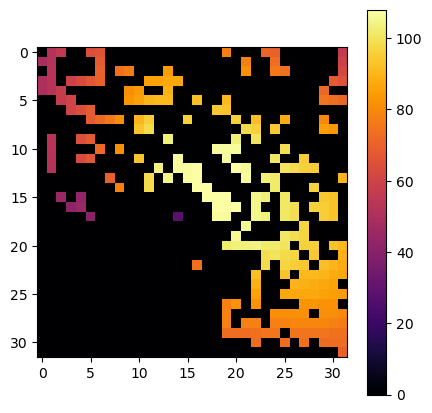

pre-restoration sum of connectivity 21858
post-restoration sum of connectivity 21272
change in connectivity: -586, or -0.0268094%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

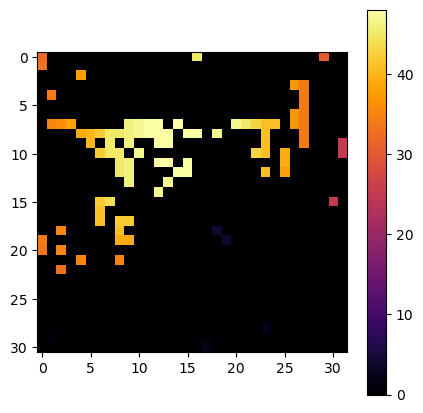

Restoring pixel (189, 203) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

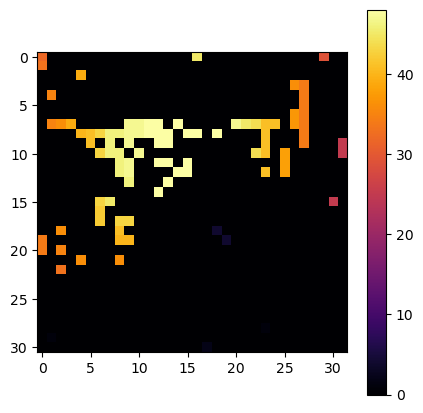

pre-restoration sum of connectivity 3705
post-restoration sum of connectivity 3737
change in connectivity: 32, or 0.008637%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

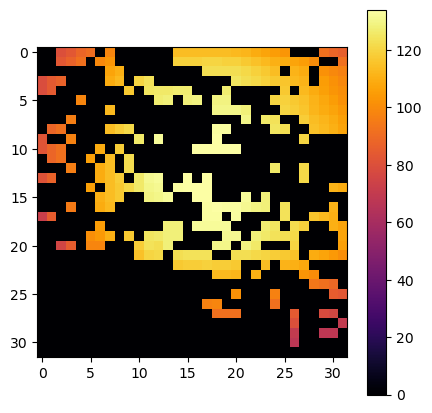

Restoring pixel (64, 129) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

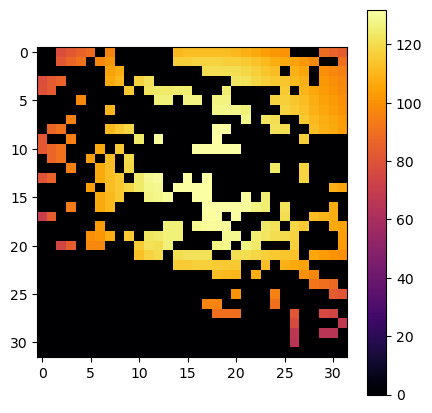

pre-restoration sum of connectivity 36079
post-restoration sum of connectivity 35399
change in connectivity: -680, or -0.0188475%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

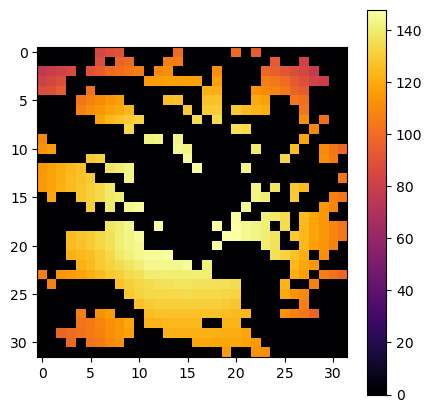

Restoring pixel (134, 168) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

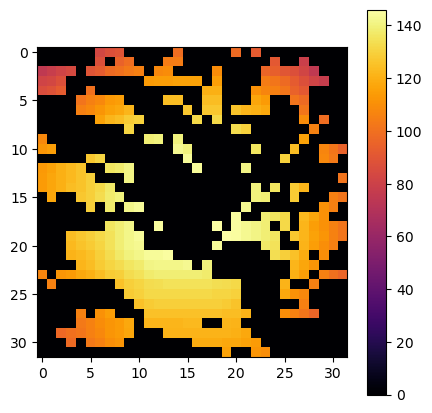

pre-restoration sum of connectivity 47042
post-restoration sum of connectivity 46368
change in connectivity: -674, or -0.0143276%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

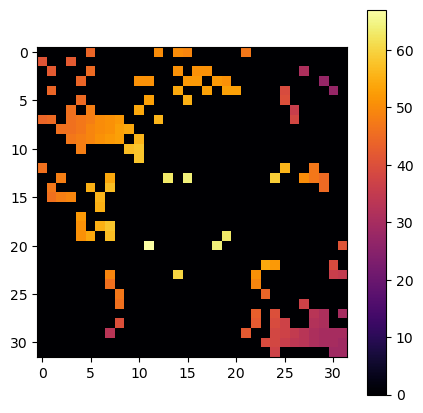

Restoring pixel (292, 199) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

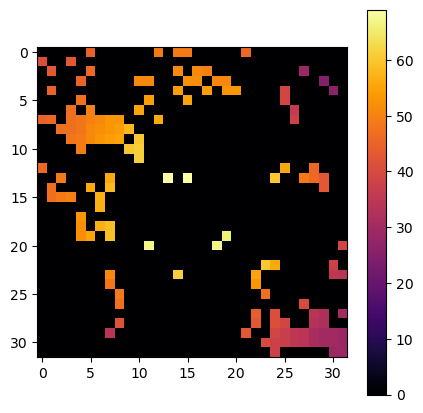

pre-restoration sum of connectivity 6551
post-restoration sum of connectivity 6681
change in connectivity: 130, or 0.0198443%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

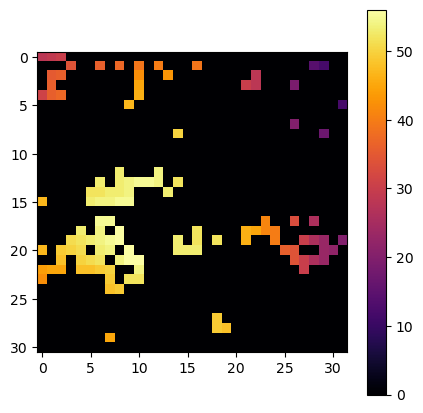

Restoring pixel (238, 203) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

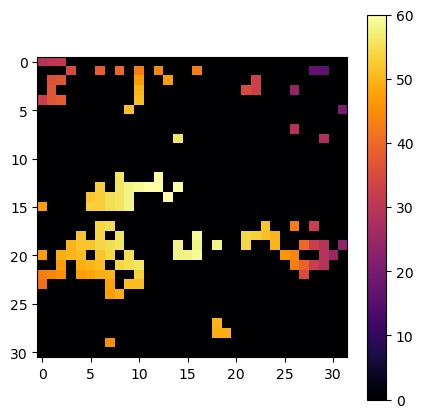

pre-restoration sum of connectivity 5364
post-restoration sum of connectivity 5727
change in connectivity: 363, or 0.0676734%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

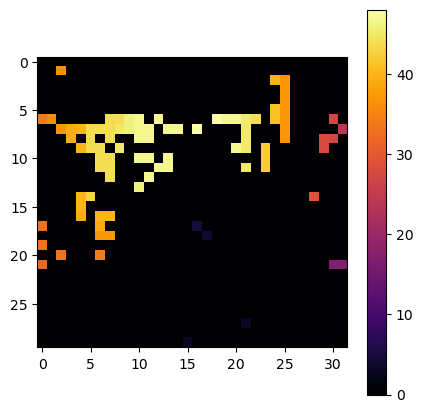

Restoring pixel (191, 204) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

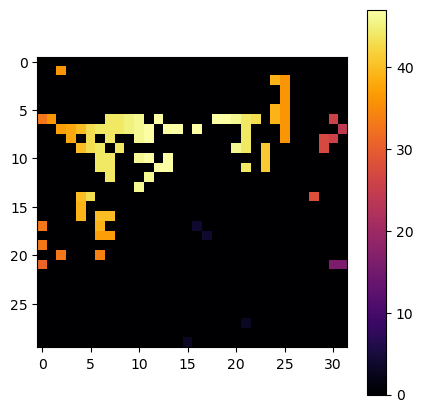

pre-restoration sum of connectivity 3548
post-restoration sum of connectivity 3498
change in connectivity: -50, or -0.0140924%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

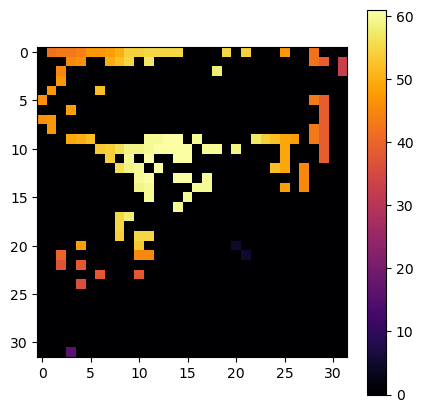

Restoring pixel (187, 201) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

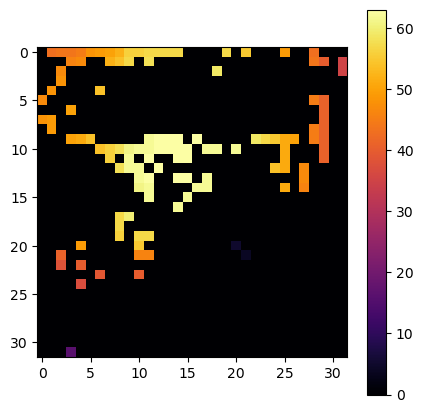

pre-restoration sum of connectivity 6117
post-restoration sum of connectivity 6336
change in connectivity: 219, or 0.0358019%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

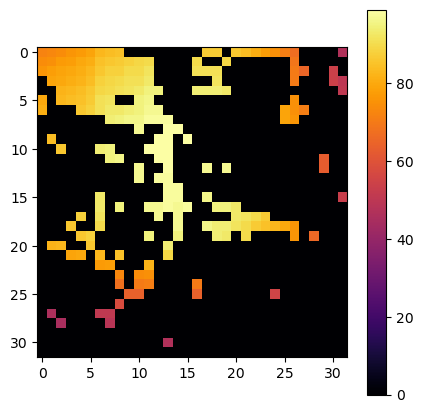

Restoring pixel (143, 191) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

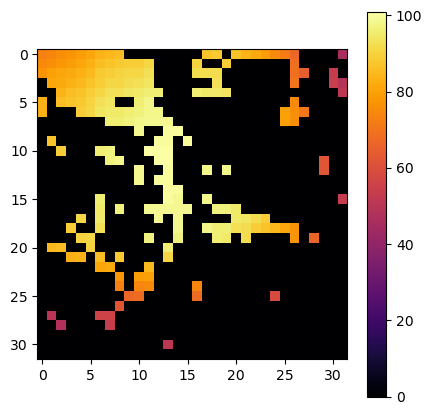

pre-restoration sum of connectivity 18435
post-restoration sum of connectivity 18833
change in connectivity: 398, or 0.0215894%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

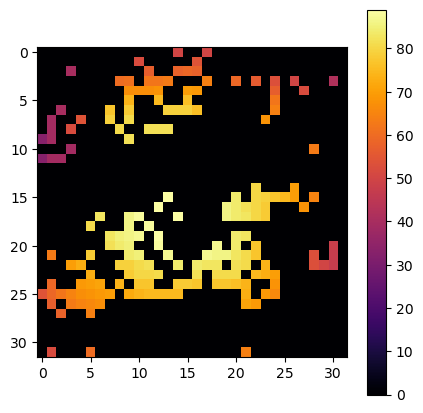

Restoring pixel (224, 201) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

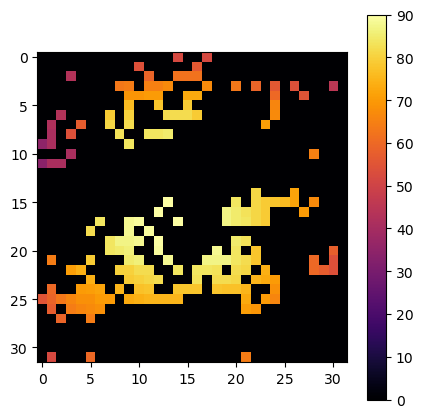

pre-restoration sum of connectivity 13315
post-restoration sum of connectivity 13608
change in connectivity: 293, or 0.0220053%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

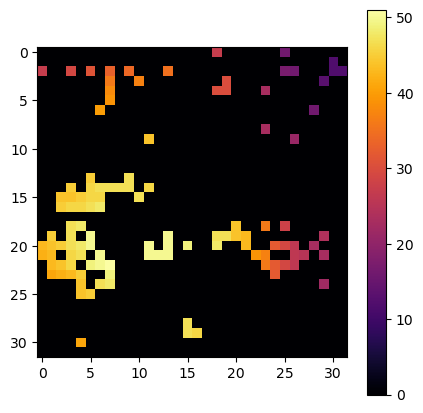

Restoring pixel (241, 202) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

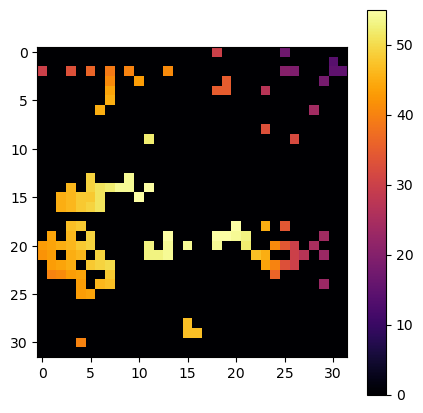

pre-restoration sum of connectivity 4486
post-restoration sum of connectivity 4852
change in connectivity: 366, or 0.0815872%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

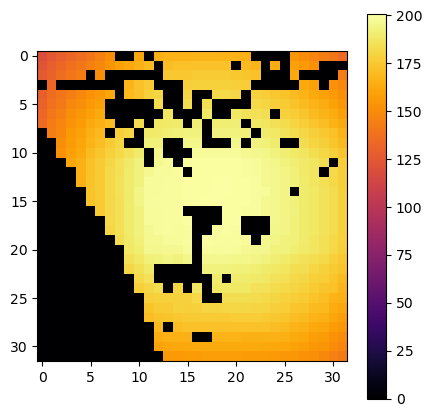

Restoring pixel (232, 21) from permiability 0.3585985401459854 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

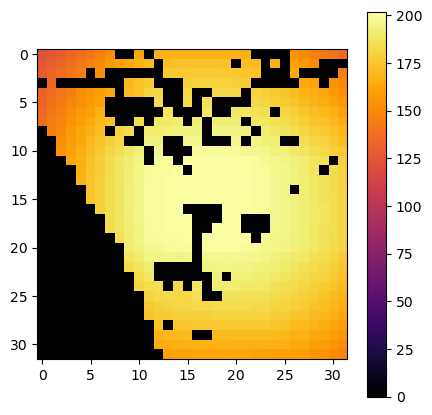

pre-restoration sum of connectivity 124149
post-restoration sum of connectivity 125707
change in connectivity: 1558, or 0.0125494%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

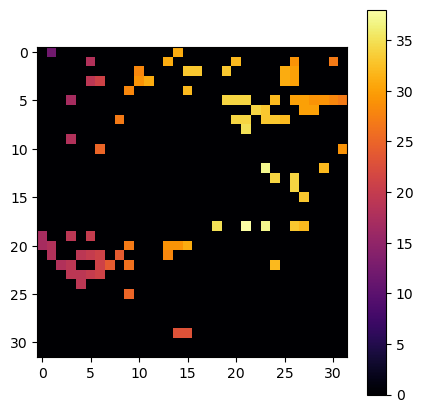

Restoring pixel (261, 201) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

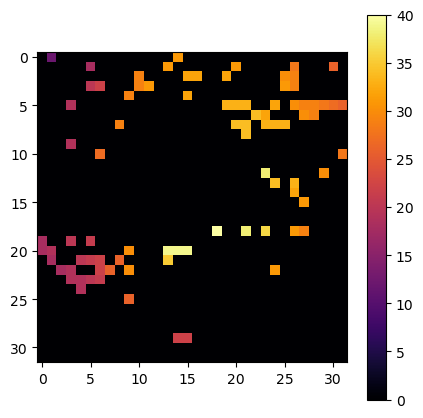

pre-restoration sum of connectivity 2365
post-restoration sum of connectivity 2403
change in connectivity: 38, or 0.0160677%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

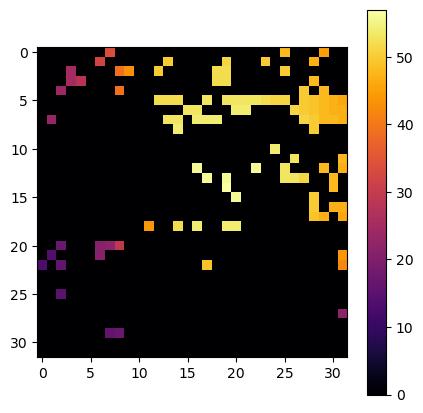

Restoring pixel (268, 201) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

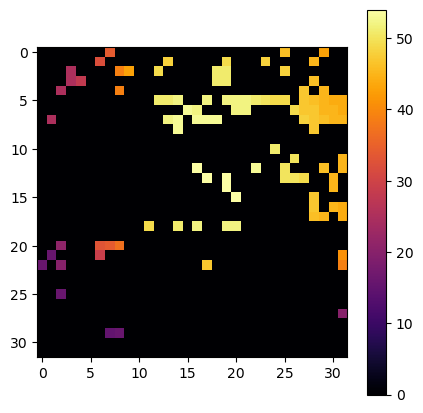

pre-restoration sum of connectivity 4839
post-restoration sum of connectivity 4724
change in connectivity: -115, or -0.0237652%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

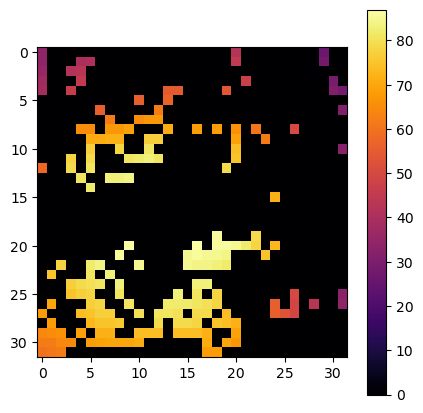

Restoring pixel (228, 196) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

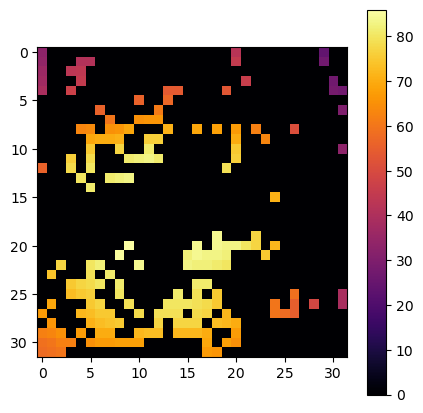

pre-restoration sum of connectivity 13124
post-restoration sum of connectivity 12932
change in connectivity: -192, or -0.0146297%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

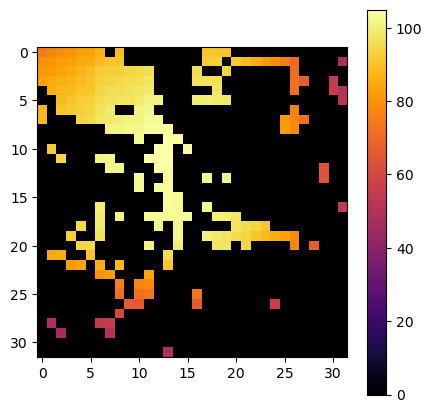

Restoring pixel (143, 190) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

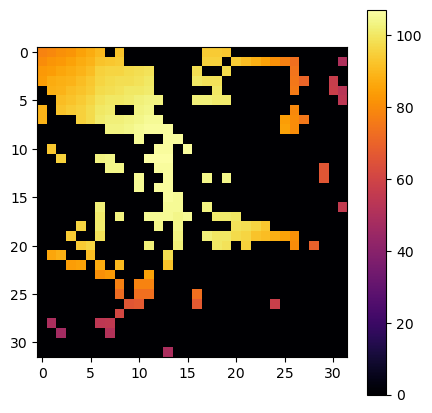

pre-restoration sum of connectivity 20495
post-restoration sum of connectivity 20935
change in connectivity: 440, or 0.0214687%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

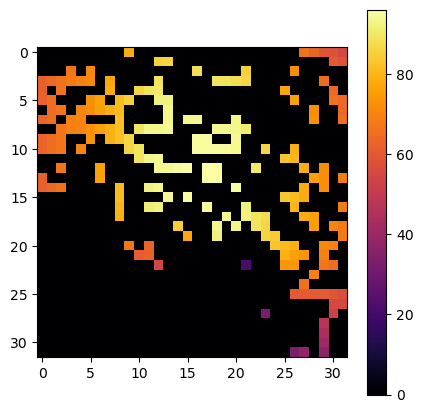

Restoring pixel (82, 142) from permiability 0.2715912408759124 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

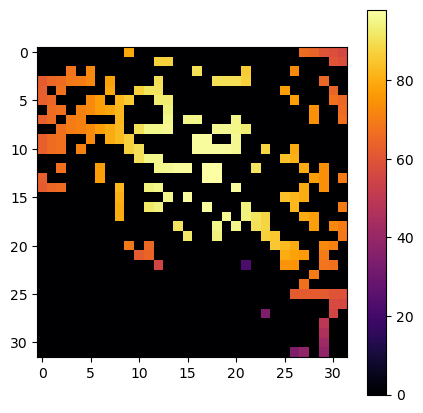

pre-restoration sum of connectivity 15840
post-restoration sum of connectivity 16121
change in connectivity: 281, or 0.0177399%
total_delta_connectivity: 6737
Average percent change: 0.03444713651481215


In [14]:
death_tif = optimizer.get_death_layer(optimizer.death_fn)
highest_death = optimizer.get_highest_death_pixels(death_tif, n=50)
print(highest_death)

ter = GeoTiff.from_file(optimizer.terrain_fn)
restored_ter = GeoTiff.from_file(optimizer.restored_terr_fn)
hab = GeoTiff.from_file(optimizer.habitat_fn)

window_sz = 16

total_delta_connectivity = 0
total_percent_change = 0.0

for i, (x, y) in enumerate(highest_death.keys()):
    lat_max, lon_max = rasterio.transform.xy(ter.dataset.transform, y-window_sz, x-window_sz)
    lat_min, lon_min = rasterio.transform.xy(ter.dataset.transform, y+window_sz, x+window_sz)

    pre_ter = ter.crop_to_new_file(PRE_TER, [lat_max, lon_min, lat_min, lon_max], padding=0)
    # pre_ter.draw_geotiff()
    pre_ter.dataset.close()

    pre_hab = hab.crop_to_new_file(PRE_HAB, [lat_max, lon_min, lat_min, lon_max], padding=0)
    # hab_tile = hab.get_all_as_tile().m.astype(np.float)
    # pre_hab.draw_geotiff()
    pre_hab.dataset.close()

    # seed = torch.randint(1, 1000, (1,))[0]
    # seed = i
    repopulation.compute_connectivity(PRE_HAB, PRE_TER, PRE_CONN, PRE_FLOW, transmission_d, single_tile=True, num_simulations=10000)

    conn = GeoTiff.from_file(PRE_CONN)
    conn.draw_geotiff()
    pre_conn_sum = optimizer.sum_of_tif(PRE_CONN)

    optimizer.change_terrain(x, y, verbose=True)
    post_ter = restored_ter.crop_to_new_file(POST_TER, [lat_max, lon_min, lat_min, lon_max], padding=0)
    # post_ter.draw_geotiff()
    post_ter.dataset.close()

    repopulation.compute_connectivity(PRE_HAB, POST_TER, POST_CONN, POST_FLOW, transmission_d, single_tile=True, num_simulations=10000)
    conn = GeoTiff.from_file(POST_CONN)
    conn.draw_geotiff()
    post_conn_sum = optimizer.sum_of_tif(POST_CONN)
    
    # change in connectivity:
    delta_conn = int(post_conn_sum) - int(pre_conn_sum)
    percent_change = delta_conn / pre_conn_sum

    total_delta_connectivity += delta_conn
    total_percent_change += percent_change

    print(f'pre-restoration sum of connectivity {pre_conn_sum}')
    print(f'post-restoration sum of connectivity {post_conn_sum}')
    print(f'change in connectivity: {delta_conn}, or {percent_change.round(7)}%')

print(f"total_delta_connectivity: {total_delta_connectivity}")
print(f"Average percent change: {total_percent_change / len(highest_death.keys())}")

In [15]:
death_sum = 0
for i in highest_death.values():
    death_sum += i

print(death_sum)


1646


6737/1646 = 4.093

About 4x more connectivity units per potential unit

TODO:
- Look at correlation between amount of permiability restored, and % change in connectivity